# Starbucks Capstone Project

### Introduction
The aim of sale promotions by companies on its products and services is to increase sales, attract new customers, encourage loyalty, and repeat purchases. These promotions usually have a lifespan and they are integrated accross various marketing channels. Inorder to run an effective and productive sales promotion, the company needs to collect and study its customers behaviour in relation to its product and services.

The customers wants to feel that the company truly undertands  them. The most important thing that makes a sales promotion productive is selecting the right target audience. By pretermining a target audience, companies can put their promotions to efficient use. This project aims to use Machine Learning to help Starbucks determine which demography of its customers will respond best to a certain type of promotion.


### Data
The dataset for this project contains simulated data that mimics customer behaviour on the Starbucks mobile reward app. This dataset is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. 

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The dataset contains transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

The data is contained in three files:
1. **profile**.json: Contains demographic data for each customer. It is made up of 17,000 customers with 5 fields.
    * gender: (categorical) M, F, O, or null.
    * age: (numeric) missing value encoded as 118.
    * id: (string/hash).
    * became_member_on: (date) format:YYYYMMDD.
    * income: (numeric).
2. **portfolio.json**: Contains data on offers sent during 30-day test period. It is made up of 10 offers with 6 fields.
    * reward: (numeric) money awarded for the amount spent.
    * channels: (list) web, email, mobile, social.
    * difficulty: (numeric) money required to be spent to receive reward.
    * duration: (numeric) time for offer to be open, in days.
    * offer_type: (string) bogo, discount, informational.
    * id: (string/hash).
3. **transcript.json**: Contains records for customer transactions, offers received, offers viewed, and offers completed. It is made up of 306648 transactions with 4 fields.
    * person: (string/hash).
    * event: (string) offer received, offer.
    * value: (dictionary) different values depending on event type:
        * offer id: (string/hash) not associated with any "transaction".
        * amount: (numeric) money spent in "transaction".
        * reward: (numeric) money gained from "offer completed".
    * time: (numeric) hours after start of test.  
    

### Benchmark
Model must have an accuracy score between 0.75 and 0.95 

In [ ]:
# Install dependencies

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.4.0
!pip install autogluon --no-cache-dir

## Exploratory data analysis

The next stage of project data collection, visualization, preprocessing, and transformation.

### Data Collection

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# read data from the json files into pandas dataframes
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Analysis and Cleaning

#### 1. Portfolio dataframe
Contains information about types of offers sent during a 30-days period

In [40]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [9]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


##### Portfolio dataframe cleaning

There are 10 rows of data and there are no null values in portfolio dataframe. 

Next steps:
1. Convert the categorical columns values in portfolio dataframe to numerical values using one hot encoding.
2. Drop original categorical columns.
3. Change the name of the 'id' column to 'offer_id' and shorten the values


In [6]:
# One hot encoding 
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio = portfolio.join(portfolio.offer_type.str.get_dummies())
# Change 'id' and 'reward' column name
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
portfolio = portfolio.rename(columns = {'reward': 'offer_reward'})
# Drop original categorical columns
portfolio.drop(['channels', 'offer_type'],axis=1,inplace=True)
# Shorten offer_id
offer_types = {'ae264e3637204a6fb9bb56bc8210ddfd':'b1',
         '4d5c57ea9a6940dd891ad53e9dbe8da0': 'b2',
         '3f207df678b143eea3cee63160fa8bed':'i1',
         '9b98b8c7a33c4b65b9aebfe6a799e6d9':'b3',
         '0b1e1539f2cc45b7b9fa7c272da2e1d7':'d1',
         '2298d6c36e964ae4a3e7e9706d1fb8c2':'d2',
         'fafdcd668e3743c1bb461111dcafc2a4':'d3',
         '5a8bc65990b245e5a138643cd4eb9837':'i2',
         'f19421c1d4aa40978ebb69ca19b0e20d':'b4',
         '2906b810c7d4411798c6938adc9daaa5':'d4'}

portfolio['offer_id'].replace(offer_types, inplace=True)
portfolio

,offer_reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,b1,1,1,1,0,1,0,0
1,10,10,5,b2,1,1,1,1,1,0,0
2,0,0,4,i1,1,1,0,1,0,0,1
3,5,5,7,b3,1,1,0,1,1,0,0
4,5,20,10,d1,1,0,0,1,0,1,0
5,3,7,7,d2,1,1,1,1,0,1,0
6,2,10,10,d3,1,1,1,1,0,1,0
7,0,0,3,i2,1,1,1,0,0,0,1
8,5,5,5,b4,1,1,1,1,1,0,0
9,2,10,7,d4,1,1,0,1,0,1,0


In [7]:
portfolio.describe()

,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000,0.400000,0.400000,0.200000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637,0.516398,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2. Profile dataframe
Contains information demographic information about customers

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# Check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are 17,000 rows in profile dataframe. Two columns in this dataframe contain 2,175 null values each, the columns are 'gender' and 'became_member_on' columns. Lets view these rows with null values. Lets view what these rows with null values look like.


Text(0, 0.5, '')

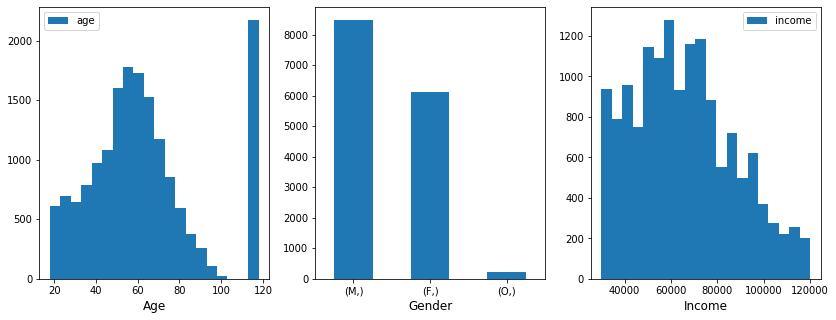

In [14]:
# profile data analysis

fig, ax = plt.subplots(1, 3, figsize=(14,5))

profile[['age']].plot(ax = ax[0],kind='hist', bins=20)
profile[['gender']].value_counts().plot(ax = ax[1], kind='bar', stacked=True, rot=0)
profile[['income']].plot(ax = ax[2], kind='hist', bins=20)

ax[0].set_xlabel('Age', fontsize=12)
ax[0].set_ylabel(None)
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel(None)
ax[2].set_xlabel('Income', fontsize=12)
ax[2].set_ylabel(None)

We can observe from the 'age' distribution that there is an outlier and that is from the maximum value in the age distribution. Let's view what this maximum age value is.

In [12]:
profile['age'].max()

118

In [13]:
# The outlier in 'age' distribution has a value of 118. Let's view rows where the value of age is 118.

profile[profile['age'] == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


##### Profile dataframe cleaning

Next steps:
1. It is observed that 'gender' column is null and 'income' column contain null values where 'age' is 118. In other words, the null values appear in both the columns for same rows. Its is advisable to drop these rows.
2. Change the name of the 'id' column to 'customer_id'.

In [7]:
# Drop rows where 'age' is 118
profile = profile[profile.age != 118]
# Change 'id' column name
profile = profile.rename(columns = {'id': 'customer_id'})
profile

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Text(0.5, 1.0, 'Gender-wise age distribution')

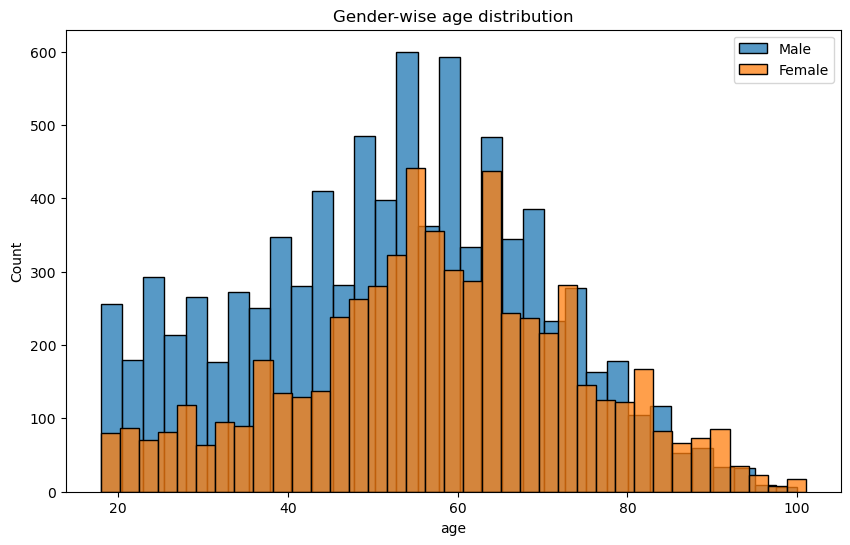

In [4]:
# Gender-wise age distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(x=profile[profile.gender == 'M'].age, label='Male',ax=ax)
sns.histplot(x=profile[profile.gender == 'F'].age, label='Female',ax=ax)
ax.legend()
ax.set_title('Gender-wise age distribution')



Text(0.5, 1.0, 'Gender-wise income distribution')

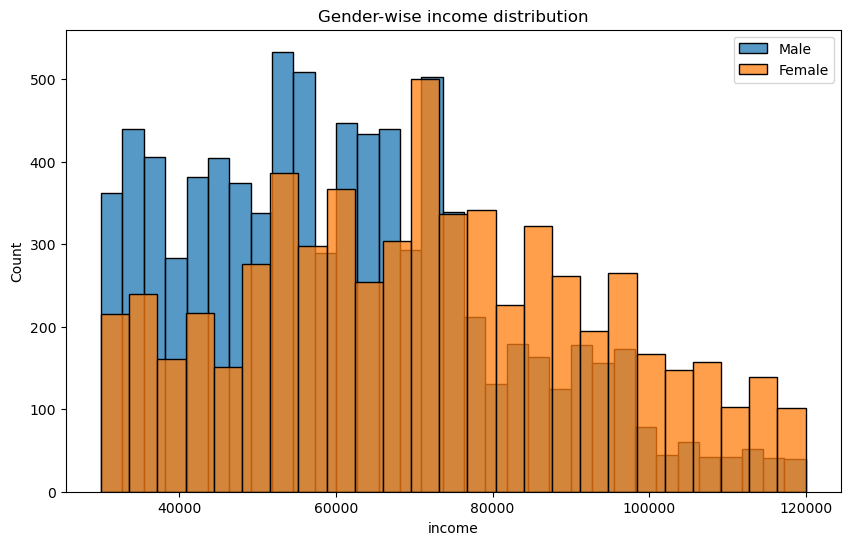

In [51]:
# Gender-wise income distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(x=profile[profile.gender=='M'].income, label='Male', ax=ax)
sns.histplot(x=profile[profile.gender=='F'].income, label='Female', ax=ax)
ax.legend()
ax.set_title('Gender-wise income distribution')

#### 3. Transcript dataframe
Contains records for customer transactions, offers received, offers viewed, and offers completed

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [16]:
#Check for null
transcript.columns.duplicated().sum()

0

There are no null values in transcript dataframe. Lets analyze the dataframe.

In [17]:
#Event types
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

From the statistics above we can see that 76,277 offers were received by the customers. 57,725 of these offers were viewed by customers and only 33,579 of these offers were completed by customers. There were 138,953 transactions during the period the offers were sent out.

In [18]:
offer_received = transcript[transcript.event == 'offer received']
offer_received.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
offer_viewed = transcript[transcript.event == 'offer viewed']
offer_viewed.head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [20]:
offer_completed = transcript[transcript.event == 'offer completed']
offer_completed.head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [21]:
transaction = transcript[transcript.event == 'transaction']
transaction.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


I think 'transaction' data does not give any useful information on offers, it will be removed.

##### Transcript dataframe cleaning

Next steps:
1. Change the name of the 'person' column to 'customer_id'.
2. Extract offer id, reward from 'value' column.
3. Drop 'value' column.
4. Remove rows where 'event' column contain 'transaction'.
5. Shorten offer_id column values.

In [8]:
# Change 'person' column name
transcript = transcript.rename(columns = {'person': 'customer_id'})
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
# Extract offer id, reward from 'value' column
temp = pd.json_normalize(transcript['value'])
temp

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [10]:
# Replace the null values with space
temp['offer_id'].fillna("", inplace = True)
temp['offer id'].fillna("", inplace = True)

# Combine the offer_id and offer id columns
temp['offer_id'] = temp['offer id'] + temp['offer_id']

# Replace the null values with 0
temp['reward'].fillna(0, inplace = True)

# Drop offer id columns
temp.drop(columns = ['offer id', 'amount'], inplace = True)
temp

,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,2906b810c7d4411798c6938adc9daaa5,0.0
3,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
...,...,...
306529,,0.0
306530,,0.0
306531,,0.0
306532,,0.0


In [11]:
# Add the 'temp' columns to the original 'transcript' dataframe
transcript = pd.concat([transcript,temp], axis = 1)
transcript.drop(columns = ['value'], inplace = True)
transcript.rename(columns = {'reward': 'reward_received'}, inplace = True)
transcript

,customer_id,event,time,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,0.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,0.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,,0.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,0.0


In [12]:
# Shorten offer_id
transcript['offer_id'].replace(offer_types, inplace=True)
# Remove transaction data from transcript dataframe
transcript = transcript[transcript.event != 'transaction']
transcript

,customer_id,event,time,offer_id,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,b3,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,d1,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,d4,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,d3,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,b2,0.0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,d2,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,d3,2.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,d1,0.0
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,d3,2.0


#### Merge dataframes

In [13]:
# Merge profile, transcript and portfolio dataframes.
df = pd.merge(profile, transcript, on='customer_id')
df = pd.merge(df, portfolio, on='offer_id')
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,408,b3,0.0,5,5,7,1,1,0,1,1,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer completed,528,b3,5.0,5,5,7,1,1,0,1,1,0,0
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer received,0,b3,0.0,5,5,7,1,1,0,1,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer viewed,6,b3,0.0,5,5,7,1,1,0,1,1,0,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer completed,132,b3,5.0,5,5,7,1,1,0,1,1,0,0


### Data Preprocessing

Data preprocessing, Feature Engineering, and Hyperparameter Tuning  will be done by AutoGluon automatically. Let's create the target column.
What makes a promotion successful? In my opinion, when offers are completed, that makes the promotion a successful. The target column will state what offer type was successful (0 - 8)


In [14]:
def create_target():
    result = []
    for index, row in df.iterrows():
        if row['event'] == 'offer completed' and row['offer_id'] == 'b1':
            result.append(1)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'b2':
            result.append(2)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'b3':
            result.append(3)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'b4':
            result.append(4)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'd1':
            result.append(5)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'd2':
            result.append(6)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'd3':
            result.append(7)
        elif row['event'] == 'offer completed' and row['offer_id'] == 'd4':
            result.append(8)
        else:
            result.append(0)
    return result

In [15]:
df['target'] = create_target()
df.head()

,gender,age,customer_id,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,408,b3,0.0,5,5,7,1,1,0,1,1,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer completed,528,b3,5.0,5,5,7,1,1,0,1,1,0,0,3
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer received,0,b3,0.0,5,5,7,1,1,0,1,1,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer viewed,6,b3,0.0,5,5,7,1,1,0,1,1,0,0,0
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,offer completed,132,b3,5.0,5,5,7,1,1,0,1,1,0,0,3


In [16]:

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['event'] = label_encoder.fit_transform(df['event'])
df['offer_id'] = label_encoder.fit_transform(df['offer_id'])
#df['gender']=df['gender'].astype('category')
df.drop(columns = ['customer_id'], inplace = True)

df.head()

,gender,age,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
0,0,55,20170715,112000.0,1,408,2,0.0,5,5,7,1,1,0,1,1,0,0,0
1,0,55,20170715,112000.0,0,528,2,5.0,5,5,7,1,1,0,1,1,0,0,3
2,0,75,20170509,100000.0,1,0,2,0.0,5,5,7,1,1,0,1,1,0,0,0
3,0,75,20170509,100000.0,2,6,2,0.0,5,5,7,1,1,0,1,1,0,0,0
4,0,75,20170509,100000.0,0,132,2,5.0,5,5,7,1,1,0,1,1,0,0,3


In [17]:
df.describe()

,gender,age,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
count,148805.000000,148805.000000,1.488050e+05,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,0.586513,54.779282,2.016645e+07,66414.119149,1.117039,354.570223,4.267551,1.078868,4.442445,7.890561,6.625207,1.0,0.917160,0.658311,0.806747,0.428978,0.418743,0.152280,1.020181
std,0.521490,17.193533,1.176936e+04,21496.947967,0.734442,198.311301,2.793435,2.452545,3.372362,5.041335,2.133035,0.0,0.275641,0.474277,0.394851,0.494932,0.493355,0.359293,2.201757
min,0.000000,18.000000,2.013073e+07,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,43.000000,2.016050e+07,51000.000000,1.000000,168.000000,2.000000,0.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,56.000000,2.017063e+07,65000.000000,1.000000,408.000000,4.000000,0.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,67.000000,2.017122e+07,81000.000000,2.000000,510.000000,6.000000,0.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,2.000000,101.000000,2.018073e+07,120000.000000,2.000000,714.000000,9.000000,10.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [27]:
from sklearn.model_selection import train_test_split

train_data, test_data  = train_test_split(df, test_size=0.2)
train_data.head()

,gender,age,became_member_on,income,event,time,offer_id,reward_received,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
104952,1,27,20170114,57000.0,2,186,5,0.0,3,7,7,1,1,1,1,0,1,0,0
148653,1,60,20180505,37000.0,2,528,1,0.0,10,10,5,1,1,1,1,1,0,0,0
577,1,74,20160924,51000.0,1,336,2,0.0,5,5,7,1,1,0,1,1,0,0,0
135646,0,64,20171126,50000.0,1,336,1,0.0,10,10,5,1,1,1,1,1,0,0,0
101534,1,48,20170615,73000.0,2,354,6,0.0,2,10,10,1,1,1,1,0,1,0,0


In [20]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor= TabularPredictor(label ='target').fit(train_data = train_data, verbosity = 2,presets='best_quality', time_limit=1200)


No path specified. Models will be saved in: "AutogluonModels/ag-20230417_162413/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230417_162413/"
AutoGluon Version:  0.7.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 14 23:44:59 UTC 2023
Train Data Rows:    119044
Train Data Columns: 18
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	9 unique label values:  [7, 3, 0, 6, 8, 4, 5, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Coun

In [21]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('float', [])     : 2 | ['income', 'reward_received']
('int', [])       : 9 | ['gender', 'age', 'became_member_on', 'event', 'time', ...]
('int', ['bool']) : 6 | ['mobile', 'social', 'web', 'bogo', 'discount', ...]


In [24]:
predictor.leaderboard()

                      model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            XGBoost_BAG_L1   1.000000       0.197880    21.866446                0.197880          21.866446            1       True         10
1           LightGBM_BAG_L1   1.000000       0.290704    34.312210                0.290704          34.312210            1       True          5
2           CatBoost_BAG_L1   1.000000       0.326516    39.862393                0.326516          39.862393            1       True          8
3         LightGBMXT_BAG_L1   1.000000       0.364420    36.887079                0.364420          36.887079            1       True          4
4    NeuralNetFastAI_BAG_L1   1.000000       2.343373   602.636636                2.343373         602.636636            1       True          3
5   RandomForestEntr_BAG_L1   1.000000       3.187282     8.386401                3.187282           8.386401            1       T

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,1.000000,0.197880,21.866446,0.197880,21.866446,1,True,10
1,LightGBM_BAG_L1,1.000000,0.290704,34.312210,0.290704,34.312210,1,True,5
2,CatBoost_BAG_L1,1.000000,0.326516,39.862393,0.326516,39.862393,1,True,8
3,LightGBMXT_BAG_L1,1.000000,0.364420,36.887079,0.364420,36.887079,1,True,4
4,NeuralNetFastAI_BAG_L1,1.000000,2.343373,602.636636,2.343373,602.636636,1,True,3
5,RandomForestEntr_BAG_L1,1.000000,3.187282,8.386401,3.187282,8.386401,1,True,7
6,WeightedEnsemble_L2,1.000000,3.202336,27.269365,0.015053,18.882964,2,True,11
7,ExtraTreesGini_BAG_L1,1.000000,3.207058,9.370468,3.207058,9.370468,1,True,9
8,RandomForestGini_BAG_L1,1.000000,4.031302,10.153343,4.031302,10.153343,1,True,6
9,LightGBM_BAG_L2,1.000000,16.497478,822.938439,0.502942,58.160717,2,True,13


In [28]:

y_test=test_data['target']
test_data=test_data.drop(['target'],axis=1)
y_pred = predictor.predict(test_data)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 1.0
Evaluations on test data:
{
    "accuracy": 1.0,
    "balanced_accuracy": 1.0,
    "mcc": 1.0
}


Predictions:  
 90708     0
97773     0
118389    0
11568     0
97653     0
         ..
97665     7
49167     0
21353     0
64371     0
58682     0
Name: target, Length: 29761, dtype: int64


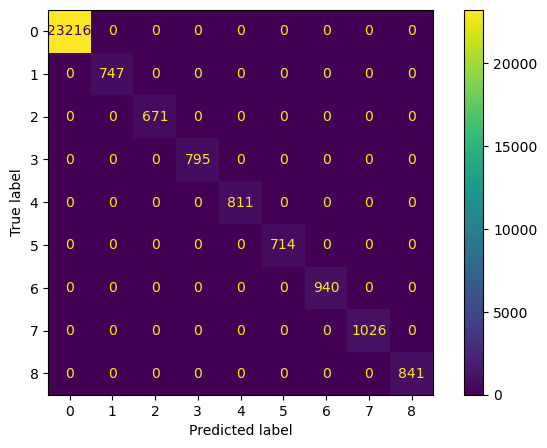

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],
)

cmp.plot(ax=ax)
plt.show();

### Hyperparameter optimization
AutoGluon carries out automatic hyperparameter tuning, I will leverage on that. A couple of columns will be dropped test and improve the models' accuracy.

In [30]:
#Hyperparameter optimization - drop some columns due to overfitting
df.drop(columns = ['became_member_on', 'event', 'reward_received'], inplace = True)

In [31]:
train_data, test_data  = train_test_split(df, test_size=0.2)
train_data.head()

,gender,age,income,time,offer_id,offer_reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,target
14953,1,21,74000.0,0,8,0,0,4,1,1,0,1,0,0,1,0
138417,1,74,98000.0,378,1,10,10,5,1,1,1,1,1,0,0,0
75766,0,88,95000.0,684,7,2,10,7,1,1,0,1,0,1,0,8
139664,0,84,102000.0,564,1,10,10,5,1,1,1,1,1,0,0,2
31242,0,67,52000.0,366,9,0,0,3,1,1,1,0,0,0,1,0


In [32]:
predictor= TabularPredictor(label ='target').fit(train_data = train_data, verbosity = 2,presets='best_quality', time_limit=1200)

No path specified. Models will be saved in: "AutogluonModels/ag-20230417_165211/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20230417_165211/"
AutoGluon Version:  0.7.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 14 23:44:59 UTC 2023
Train Data Rows:    119044
Train Data Columns: 15
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	9 unique label values:  [0, 8, 2, 6, 7, 4, 3, 1, 5]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Coun

In [33]:
predictor.leaderboard()

                    model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBMXT_BAG_L2   0.829794      51.717080   898.108155                5.452988         103.010762            2       True          7
1     WeightedEnsemble_L3   0.829794      51.736223   906.474931                0.019143           8.366776            3       True          8
2  NeuralNetFastAI_BAG_L2   0.826543      48.898402  1065.965925                2.634310         270.868532            2       True          6
3       LightGBMXT_BAG_L1   0.814044      41.384541   203.482751               41.384541         203.482751            1       True          4
4     WeightedEnsemble_L2   0.814044      41.398492   214.062045                0.013952          10.579294            2       True          5
5  NeuralNetFastAI_BAG_L1   0.800721       2.367486   591.055479                2.367486         591.055479            1       True          3

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,0.829794,51.717080,898.108155,5.452988,103.010762,2,True,7
1,WeightedEnsemble_L3,0.829794,51.736223,906.474931,0.019143,8.366776,3,True,8
2,NeuralNetFastAI_BAG_L2,0.826543,48.898402,1065.965925,2.634310,270.868532,2,True,6
3,LightGBMXT_BAG_L1,0.814044,41.384541,203.482751,41.384541,203.482751,1,True,4
4,WeightedEnsemble_L2,0.814044,41.398492,214.062045,0.013952,10.579294,2,True,5
5,NeuralNetFastAI_BAG_L1,0.800721,2.367486,591.055479,2.367486,591.055479,1,True,3
6,KNeighborsUnif_BAG_L1,0.764087,1.248351,0.366317,1.248351,0.366317,1,True,1
7,KNeighborsDist_BAG_L1,0.738550,1.263715,0.192846,1.263715,0.192846,1,True,2


In [35]:
predictor.feature_importance(data=train_data)

These features in provided data are not utilized by the predictor and will be ignored: ['email']
Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
	976.88s	= Expected runtime (195.38s per shuffle set)
	765.16s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
mobile,0.01100,0.001934,0.000110,5,0.014982,0.007018
time,0.00268,0.004740,0.137411,5,0.012441,-0.007081
informational,-0.01316,0.001889,0.999950,5,-0.009271,-0.017049
discount,-0.01516,0.002995,0.999826,5,-0.008994,-0.021326
web,-0.01544,0.002543,0.999915,5,-0.010203,-0.020677
social,-0.01676,0.003141,0.999859,5,-0.010292,-0.023228
gender,-0.01792,0.003019,0.999907,5,-0.011705,-0.024135
bogo,-0.02788,0.000415,1.000000,5,-0.027026,-0.028734
duration,-0.06220,0.003530,0.999999,5,-0.054932,-0.069468
difficulty,-0.06316,0.003743,0.999999,5,-0.055454,-0.070866


In [37]:
y_test=test_data['target']
test_data=test_data.drop(['target'],axis=1)

y_pred = predictor.predict(test_data)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.829172406841168
Evaluations on test data:
{
    "accuracy": 0.829172406841168,
    "balanced_accuracy": 0.6210822553138187,
    "mcc": 0.55070027591
}


Predictions:  
 36450     0
108618    0
68181     4
107388    0
71167     0
         ..
27699     0
14327     0
57920     0
99612     0
147427    0
Name: target, Length: 29761, dtype: int64


In [38]:
y_prob = predictor.predict_proba(test_data)
y_prob.head()

,0,1,2,3,4,5,6,7,8
36450,0.998344,0.000209,0.000166,0.000208,0.000211,0.000167,0.000243,0.000257,0.000195
108618,0.781593,0.001518,0.001385,0.001745,0.001694,0.001400,0.206815,0.002217,0.001634
68181,0.376230,0.001560,0.001545,0.001807,0.611468,0.001439,0.002126,0.002147,0.001679
107388,0.531951,0.001485,0.001355,0.001707,0.001658,0.001369,0.456329,0.002548,0.001598
71167,0.936419,0.000908,0.000829,0.001045,0.001013,0.000838,0.001217,0.001256,0.056474


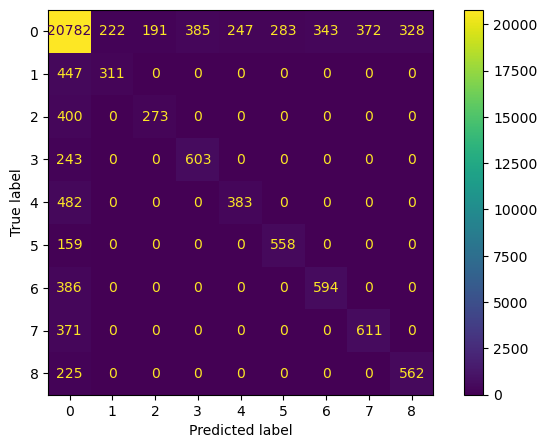

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8],
)

cmp.plot(ax=ax)
plt.show();

In [104]:
from sklearn.metrics import roc_auc_score

In [42]:
# Calculate ROC_AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
  )

0.9032555452713074

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     23153
           1       0.58      0.41      0.48       758
           2       0.59      0.41      0.48       673
           3       0.61      0.71      0.66       846
           4       0.61      0.44      0.51       865
           5       0.66      0.78      0.72       717
           6       0.63      0.61      0.62       980
           7       0.62      0.62      0.62       982
           8       0.63      0.71      0.67       787

    accuracy                           0.83     29761
   macro avg       0.65      0.62      0.63     29761
weighted avg       0.83      0.83      0.83     29761



#### Conclusion
The model precision score of 0.88 and F1-score of 0.89 shows that the model did not overfit.